In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Stil ayarları
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [15]:
# Create output directory
output_dir = 'final_analysis_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"'{output_dir}' directory created")

def load_data():
    """Load and merge datasets"""
    print("Loading datasets...")
    
    # Coffee and sleep data
    coffee_sleep_file = 'raw_datas/coffee_sleep_data.csv'
    if not os.path.exists(coffee_sleep_file):
        print(f"Error: {coffee_sleep_file} file not found!")
        return None
    
    # Weather data
    weather_file = 'raw_datas/weather_data_istanbul.csv'
    if not os.path.exists(weather_file):
        print(f"Error: {weather_file} file not found!")
        return None
    
    # Academic calendar data
    academic_file = 'raw_datas/academic_calendar.csv'
    if not os.path.exists(academic_file):
        print(f"Error: {academic_file} file not found!")
        return None
    
    # Read data
    coffee_sleep_df = pd.read_csv(coffee_sleep_file)
    weather_df = pd.read_csv(weather_file)
    academic_df = pd.read_csv(academic_file)
    
    # Convert date columns to the correct format
    coffee_sleep_df['Date'] = pd.to_datetime(coffee_sleep_df['Date'], format='%d.%m.%Y')
    weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d.%m.%Y')
    academic_df['Date'] = pd.to_datetime(academic_df['Date'], format='%d.%m.%Y')
    
    # Convert boolean column to the correct format
    academic_df['DoYouHaveAnySubmissionOrExam'] = academic_df['DoYouHaveAnySubmissionOrExam'].map({'true': True, 'false': False})
    
    # If it's a string, convert the text to lowercase and compare with True/False
    if academic_df['DoYouHaveAnySubmissionOrExam'].dtype == 'object':
        academic_df['DoYouHaveAnySubmissionOrExam'] = academic_df['DoYouHaveAnySubmissionOrExam'].astype(str).str.lower().map({'true': True, 'false': False})
    
    # Match column names for merging
    weather_df.rename(columns={'date': 'Date'}, inplace=True)
    
    # Merge data (inner join - only dates available in both sets)
    merged_df = pd.merge(coffee_sleep_df, weather_df, on='Date', how='inner')
    merged_df = pd.merge(merged_df, academic_df, on='Date', how='inner')
    
    # Convert sleep hours to minutes (for analysis)
    merged_df['SleepMinutes'] = merged_df['SleepingHours'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    merged_df['SleepHours'] = merged_df['SleepMinutes'] / 60
    
    # Add days of the week
    merged_df['DayOfWeek'] = merged_df['Date'].dt.day_name()
    merged_df['WeekDay'] = merged_df['Date'].dt.dayofweek < 5  # Weekday: True, Weekend: False
    merged_df['WeekDayStr'] = merged_df['WeekDay'].map({True: 'Weekday', False: 'Weekend'})
    
    # Convert categories from Boolean to String
    merged_df['HasExamOrSubmission'] = merged_df['DoYouHaveAnySubmissionOrExam'].map({True: 'Yes', False: 'No'})
    
    print(f"Merged dataset: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
    print("Boolean column status:", merged_df['DoYouHaveAnySubmissionOrExam'].value_counts())
    
    return merged_df

# def analyze_correlations(df):
This function begins by selecting the key numerical variables—daily coffee cups, sleep hours, average temperature, precipitation, and cloud cover—and computing their Pearson correlation matrix. It then renders a heatmap of these pairwise correlations, saving it as correlation_matrix.png. Finally, it scans the row corresponding to coffee consumption and prints out, for each other variable, the correlation coefficient along with a qualitative descriptor (“strong/ moderate/ weak” and “positive/ negative”). This gives a quick overview of which factors tend to move in tandem with (or opposite to) coffee intake.

In [16]:
def analyze_correlations(df):
    """Analyze and visualize correlations between variables"""
    print("\nAnalyzing correlations between variables...")
    
    # Calculate correlations between main variables
    numeric_cols = ['CupsOfCoffee', 'SleepHours', 'avg_temp', 'precipitation', 'cloud_cover']
    correlation_matrix = df[numeric_cols].corr()
    
    # Correlation matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix Between Variables')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlation_matrix.png')
    
    # Print important correlations
    print("\nImportant Correlations:")
    for col in numeric_cols:
        if col != 'CupsOfCoffee':
            corr = correlation_matrix.loc['CupsOfCoffee', col]
            direction = "positive" if corr > 0 else "negative"
            strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
            print(f"{strength} {direction} correlation between coffee consumption and {col}: {corr:.3f}")

# def weather_coffee_analysis(df):
Focusing purely on meteorological drivers, this function generates three visual analyses. First, it creates a scatterplot of daily average temperature versus cups of coffee, overlays a linear regression line, annotates the plot with the exact correlation coefficient, and saves it. Next, it bins precipitation into categories (none, light, moderate, heavy) and draws a boxplot of coffee consumption across these bins, highlighting how rainfall intensity affects drinking habits. Finally, it categorizes days by cloud cover percentage (few, partly cloudy, mostly cloudy, overcast) and produces a corresponding boxplot. Each plot is saved to the output directory, giving a multi-facet view of how weather relates to coffee use.

In [17]:
def weather_coffee_analysis(df):
    """Analyze the relationship between weather and coffee consumption"""
    print("\nAnalyzing the relationship between weather and coffee consumption...")
    
    # 1. Temperature and coffee consumption
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='avg_temp', y='CupsOfCoffee', data=df, alpha=0.7, s=100)
    
    # Regression line
    sns.regplot(x='avg_temp', y='CupsOfCoffee', data=df, scatter=False, 
                line_kws={"color":"red", "alpha":0.7, "lw":2, "ls":"--"})
    
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Relationship Between Temperature and Coffee Consumption')
    
    # Add correlation value
    corr = df['avg_temp'].corr(df['CupsOfCoffee'])
    plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/temperature_coffee_relationship.png')
    
    # 2. Precipitation and coffee consumption
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=pd.cut(df['precipitation'], bins=[0, 0.1, 1, 2, 100], 
                         labels=['No Precipitation', 'Light Precipitation', 'Moderate Precipitation', 'Heavy Precipitation']), 
                y='CupsOfCoffee', data=df)
    
    plt.xlabel('Precipitation Category')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Relationship Between Precipitation Amount and Coffee Consumption')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/precipitation_coffee_relationship.png')
    
    # 3. Cloud cover and coffee consumption
    plt.figure(figsize=(12, 6))
    
    # Create cloud cover categories
    df['cloud_category'] = pd.cut(df['cloud_cover'], 
                                 bins=[0, 25, 50, 75, 100], 
                                 labels=['Few Clouds (0-25%)', 'Partly Cloudy (25-50%)', 
                                         'Mostly Cloudy (50-75%)', 'Overcast (75-100%)'])
    
    sns.boxplot(x='cloud_category', y='CupsOfCoffee', data=df)
    plt.xlabel('Cloud Cover Category')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Relationship Between Cloud Cover and Coffee Consumption')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/cloud_coffee_relationship.png')

# def academic_coffee_analysis(df):
This routine compares coffee consumption on days with academic pressure (exams or submissions) versus normal days. It splits the data into “exam days” and “non-exam days,” prints their counts, and then constructs a bar chart of the average cups consumed in each group, annotating the bars with their numeric values. If there are at least two observations in both groups, it performs an independent two-sample t-test (unequal variances) and reports the t-statistic, p-value, and whether the difference is statistically significant at the 0.05 level—albeit noting if data are insufficient for valid testing.

In [18]:
def academic_coffee_analysis(df):
    """Analyze the relationship between academic events and coffee consumption"""
    print("\nAnalyzing the relationship between academic events and coffee consumption...")
    
    # Check exam/assignment submission days
    exam_days = df[df['DoYouHaveAnySubmissionOrExam'] == True]
    no_exam_days = df[df['DoYouHaveAnySubmissionOrExam'] == False]
    
    print(f"\nExam/Assignment Days vs Normal Days Analysis:")
    print(f"Number of exam/assignment days: {len(exam_days)}")
    print(f"Number of normal days: {len(no_exam_days)}")
    
    if len(exam_days) > 0 and len(no_exam_days) > 0:
        # Compare coffee consumption on exam/assignment days
        plt.figure(figsize=(10, 6))
        
        # Prepare data for barplot
        exam_summary = pd.DataFrame({
            'Status': ['Exam/Assignment Days', 'Normal Days'],
            'Average Coffee': [exam_days['CupsOfCoffee'].mean(), no_exam_days['CupsOfCoffee'].mean()]
        })
        
        sns.barplot(x='Status', y='Average Coffee', data=exam_summary)
        
        plt.xlabel('Exam or Assignment Submission Status')
        plt.ylabel('Average Number of Coffee Cups')
        plt.title('Coffee Consumption on Exam/Assignment Days')
        
        # Print average values
        for i, val in enumerate(exam_summary['Average Coffee']):
            plt.text(i, val + 0.1, f'{val:.2f}', ha='center')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/academic_coffee_relationship.png')
        
        # Detailed analysis with t-test
        import scipy.stats as stats
        
        exam_coffee = exam_days['CupsOfCoffee']
        no_exam_coffee = no_exam_days['CupsOfCoffee']
        
        if len(exam_coffee) >= 2 and len(no_exam_coffee) >= 2:
            t_stat, p_value = stats.ttest_ind(exam_coffee, no_exam_coffee, equal_var=False)
            
            print(f"Average coffee consumption on exam/assignment days: {exam_coffee.mean():.2f} cups")
            print(f"Average coffee consumption on normal days: {no_exam_coffee.mean():.2f} cups")
            print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")
            
            # Print significance test
            alpha = 0.05
            if p_value < alpha:
                print(f"Result: Statistically significant difference found (p<{alpha}).")
                if exam_coffee.mean() > no_exam_coffee.mean():
                    print("Coffee consumption is significantly higher on exam/assignment days.")
                else:
                    print("Coffee consumption is significantly lower on exam/assignment days.")
            else:
                print(f"Result: No statistically significant difference found (p>{alpha}).")
        else:
            print("Insufficient data: T-test could not be applied (at least 2 data points needed for each group).")
            print(f"Average coffee consumption on exam/assignment days: {exam_coffee.mean():.2f} cups")
            print(f"Average coffee consumption on normal days: {no_exam_coffee.mean():.2f} cups")
    else:
        print("Insufficient data for exam/assignment days or normal days. Analysis could not be performed.")

# def sleep_coffee_analysis(df):
- Here the relationship between sleep and caffeine is examined. First, it plots sleep duration versus coffee consumption—differentiating weekdays and weekends by hue and sizing points by consumption—and fits a regression line, annotating the overall correlation. Next, it defines three sleep-duration categories (insufficient, normal, long) and displays a boxplot of coffee use for each category. Finally, it shifts the sleep column by one day to relate prior-night sleep to that day’s coffee, re-plotting scatter and regression for this lagged relationship. Each step is saved as a separate figure.

In [21]:
def sleep_coffee_analysis(df):
    """Analyze the relationship between sleep and coffee consumption"""
    print("\nAnalyzing the relationship between sleep and coffee consumption...")
    
    # 1. Relationship between sleep duration and coffee consumption
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='SleepHours', y='CupsOfCoffee', hue='WeekDayStr', 
                    size='CupsOfCoffee', sizes=(50, 200), 
                    palette='viridis', data=df)
    
    # Regression line
    sns.regplot(x='SleepHours', y='CupsOfCoffee', data=df, scatter=False, 
                line_kws={"color":"red", "alpha":0.7, "lw":2, "ls":"--"})
    
    plt.xlabel('Sleep Duration (Hours)')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Relationship Between Sleep Duration and Coffee Consumption')
    
    # Add correlation value
    corr = df['SleepHours'].corr(df['CupsOfCoffee'])
    plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.legend(title='Day Type')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/sleep_coffee_relationship.png')
    
    # 2. Coffee consumption by sleep categories
    # Create sleep categories
    df['sleep_category'] = pd.cut(df['SleepHours'], 
                                 bins=[0, 6, 7, 10], 
                                 labels=['Insufficient Sleep (<6 hours)', 'Normal Sleep (6-7 hours)', 
                                         'Long Sleep (>7 hours)'])
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='sleep_category', y='CupsOfCoffee', data=df)
    plt.xlabel('Sleep Duration Category')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Coffee Consumption by Sleep Duration Categories')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/sleep_category_coffee_relationship.png')
    
    # 3. Previous day's sleep duration and today's coffee consumption
    # Calculate previous day's sleep duration
    df['PrevDaySleep'] = df['SleepHours'].shift(1)
    
    # Remove NaN values
    prev_sleep_df = df.dropna(subset=['PrevDaySleep'])
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='PrevDaySleep', y='CupsOfCoffee', hue='WeekDayStr', 
                    size='CupsOfCoffee', sizes=(50, 200), 
                    palette='viridis', data=prev_sleep_df)
    
    # Regression line
    sns.regplot(x='PrevDaySleep', y='CupsOfCoffee', data=prev_sleep_df, scatter=False, 
                line_kws={"color":"red", "alpha":0.7, "lw":2, "ls":"--"})
    
    plt.xlabel('Previous Day\'s Sleep Duration (Hours)')
    plt.ylabel('Number of Coffee Cups')
    plt.title('Relationship Between Previous Day\'s Sleep Duration and Today\'s Coffee Consumption')
    
    # Add correlation value
    corr = prev_sleep_df['PrevDaySleep'].corr(prev_sleep_df['CupsOfCoffee'])
    plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.legend(title='Day Type')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/previous_day_sleep_coffee_relationship.png')

# combined_factors_analysis(df)
- This comprehensive function weaves all factors into both visual and statistical summaries. It starts with a four-panel time series: cups of coffee (with exam days marked), sleep hours, temperature, and a dual-axis chart of precipitation and cloud cover—all aligned on the same date axis. Next, it fits a multiple linear regression (using sleep, temperature, precipitation, cloud cover, exam status, and weekday flag as predictors) to model daily coffee consumption. It prints the fitted coefficients, intercept, R² score, and ranks the predictors by absolute effect size. Finally, it produces a 3D scatter of the two most influential factors against coffee intake, coloring points by consumption, to visually highlight their joint impact. All outputs are saved to the final_analysis_output directory.

In [22]:
def combined_factors_analysis(df):
    """Analyze the combined effect of all factors"""
    print("\nAnalyzing the combined effect of all factors...")
    
    # 1. Time series graph - Show all variables together
    plt.figure(figsize=(14, 10))
    
    # First graph: Coffee consumption
    ax1 = plt.subplot(4, 1, 1)
    ax1.plot(df['Date'], df['CupsOfCoffee'], 'o-', color='brown', markersize=6, linewidth=2)
    ax1.set_ylabel('Coffee (Cups)')
    ax1.set_title('Coffee Consumption Time Series')
    ax1.grid(True, alpha=0.3)
    
    # Mark exam days
    exam_days = df[df['DoYouHaveAnySubmissionOrExam'] == True]
    if not exam_days.empty:
        for date in exam_days['Date']:
            ax1.axvline(x=date, color='red', linestyle='--', alpha=0.3)
    
    # Second graph: Sleep duration
    ax2 = plt.subplot(4, 1, 2, sharex=ax1)
    ax2.plot(df['Date'], df['SleepHours'], 'o-', color='blue', markersize=6, linewidth=2)
    ax2.set_ylabel('Sleep (Hours)')
    ax2.set_title('Sleep Duration Time Series')
    ax2.grid(True, alpha=0.3)
    
    # Third graph: Temperature
    ax3 = plt.subplot(4, 1, 3, sharex=ax1)
    ax3.plot(df['Date'], df['avg_temp'], 'o-', color='red', markersize=6, linewidth=2)
    ax3.set_ylabel('Temperature (°C)')
    ax3.set_title('Average Temperature Time Series')
    ax3.grid(True, alpha=0.3)
    
    # Fourth graph: Precipitation and cloud cover
    ax4 = plt.subplot(4, 1, 4, sharex=ax1)
    ax4.bar(df['Date'], df['precipitation'], color='skyblue', alpha=0.7, label='Precipitation (mm)')
    
    ax5 = ax4.twinx()
    ax5.plot(df['Date'], df['cloud_cover'], 'o-', color='navy', markersize=4, linewidth=1.5, label='Cloud Cover (%)')
    ax5.set_ylabel('Cloud Cover (%)')
    
    ax4.set_ylabel('Precipitation (mm)')
    ax4.set_title('Precipitation and Cloud Cover Time Series')
    ax4.set_xlabel('Date')
    ax4.grid(True, alpha=0.3)
    
    # Manually create legend
    lines4, labels4 = ax4.get_legend_handles_labels()
    lines5, labels5 = ax5.get_legend_handles_labels()
    ax4.legend(lines4 + lines5, labels4 + labels5, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_variables_time_series.png')
    
    # 2. Simple multiple regression analysis (using sklearn)
    from sklearn.linear_model import LinearRegression
    
    print("\nMultiple Regression Analysis:")
    
    # Data preparation - numerical variables
    X_numeric = df[['SleepHours', 'avg_temp', 'precipitation', 'cloud_cover']].values
    
    # Categorical variables - manual conversion
    has_exam = np.array([1 if x else 0 for x in df['DoYouHaveAnySubmissionOrExam']]).reshape(-1, 1)
    is_weekday = np.array([1 if x else 0 for x in df['WeekDay']]).reshape(-1, 1)
    
    # Combine all features
    X = np.concatenate([X_numeric, has_exam, is_weekday], axis=1)
    y = df['CupsOfCoffee'].values
    
    # Create and train model
    model = LinearRegression()
    model.fit(X, y)
    
    # Display results
    feature_names = ['Sleep Duration', 'Temperature', 'Precipitation', 'Cloud Cover', 'Exam/Assignment', 'Weekday']
    
    print("\nCoefficients:")
    for name, coef in zip(feature_names, model.coef_):
        direction = "increasing" if coef > 0 else "decreasing"
        print(f"- {name}: {direction} effect on coffee consumption (coefficient={coef:.4f})")
    
    print(f"\nConstant (Intercept): {model.intercept_:.4f}")
    print(f"Model R² score: {model.score(X, y):.4f}")
    
    # Determine most influential factors
    abs_coefs = np.abs(model.coef_)
    sorted_idx = np.argsort(abs_coefs)[::-1]  # Sort from largest to smallest
    
    print("\nMost influential factors (by absolute magnitude):")
    for i in range(len(sorted_idx)):
        idx = sorted_idx[i]
        print(f"{i+1}. {feature_names[idx]}: {model.coef_[idx]:.4f}")
    
    # 3D visualization for the two most influential factors
    if len(sorted_idx) >= 2:
        top_idx1 = sorted_idx[0]
        top_idx2 = sorted_idx[1]
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        factor1 = X[:, top_idx1]
        factor2 = X[:, top_idx2]
        
        scatter = ax.scatter(factor1, factor2, y, c=y, cmap='viridis', s=50, alpha=0.8)
        
        ax.set_xlabel(feature_names[top_idx1])
        ax.set_ylabel(feature_names[top_idx2])
        ax.set_zlabel('Coffee Consumption (Cups)')
        
        plt.colorbar(scatter, ax=ax, label='Coffee Consumption (Cups)')
        plt.title(f'Two Most Influential Factors: {feature_names[top_idx1]} and {feature_names[top_idx2]}')
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/most_influential_factors_3d.png')

# First we will load the data before we call the functions.

In [23]:
#First we will load the data.
df = load_data()
continue_ = True

if df is None or df.empty:
    print("Error: Data could not be loaded or merged.")
    continue_ = False

Loading datasets...
Merged dataset: 44 rows, 13 columns
Boolean column status: DoYouHaveAnySubmissionOrExam
False    33
True     10
Name: count, dtype: int64



Analyzing correlations between variables...

Important Correlations:
strong negative correlation between coffee consumption and SleepHours: -0.728
weak negative correlation between coffee consumption and avg_temp: -0.212
weak negative correlation between coffee consumption and precipitation: -0.185
weak negative correlation between coffee consumption and cloud_cover: -0.032


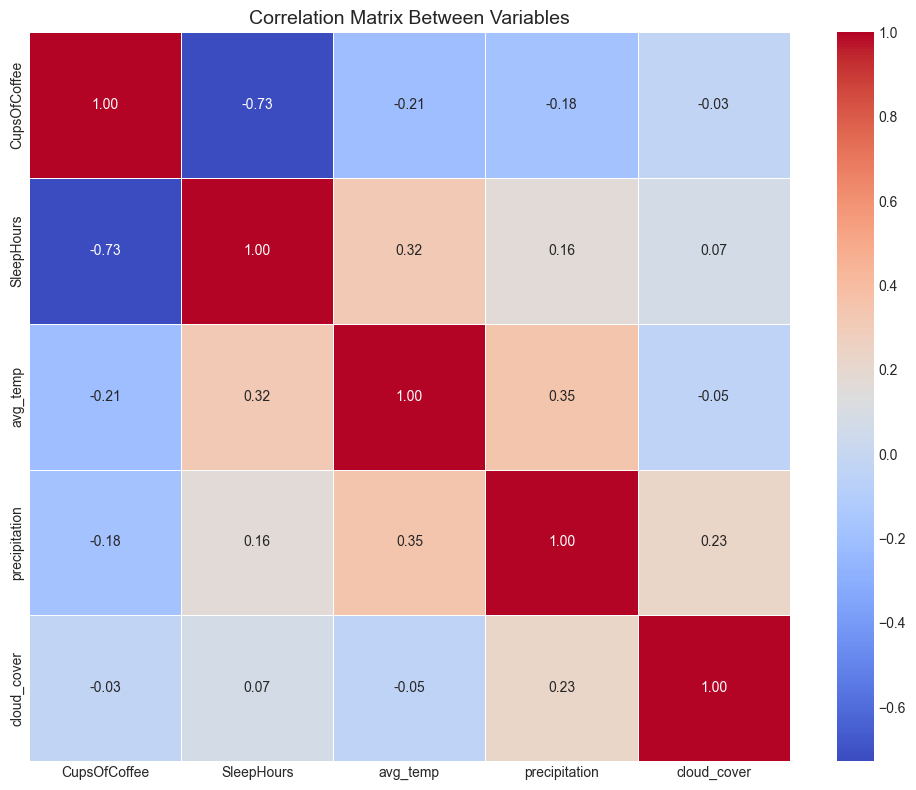

In [26]:
analyze_correlations(df)


Analyzing the relationship between weather and coffee consumption...


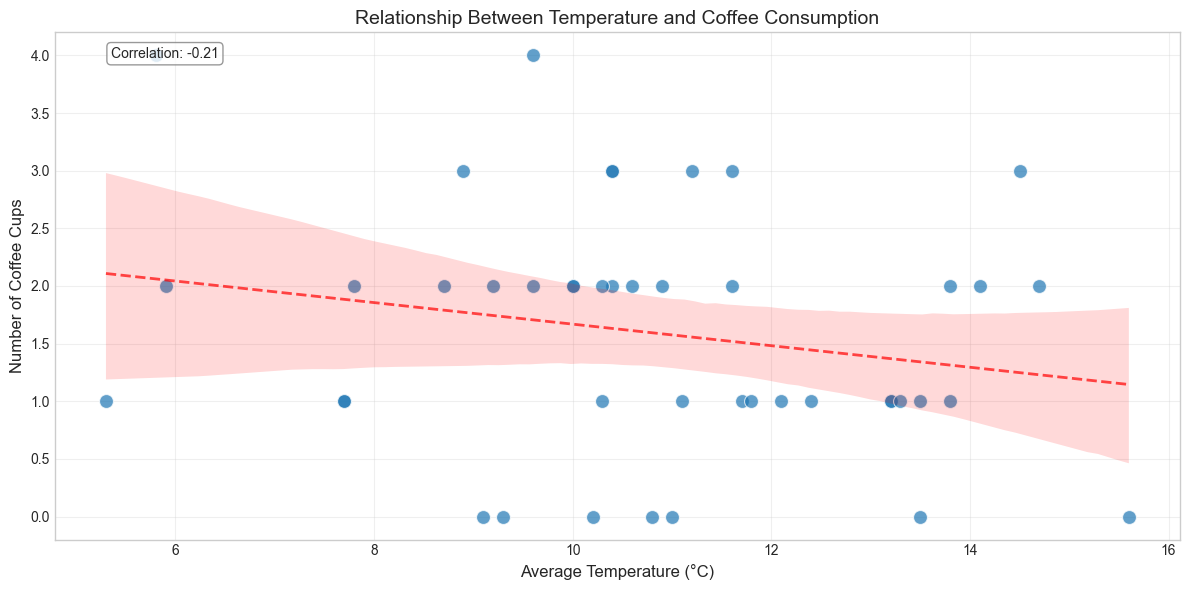

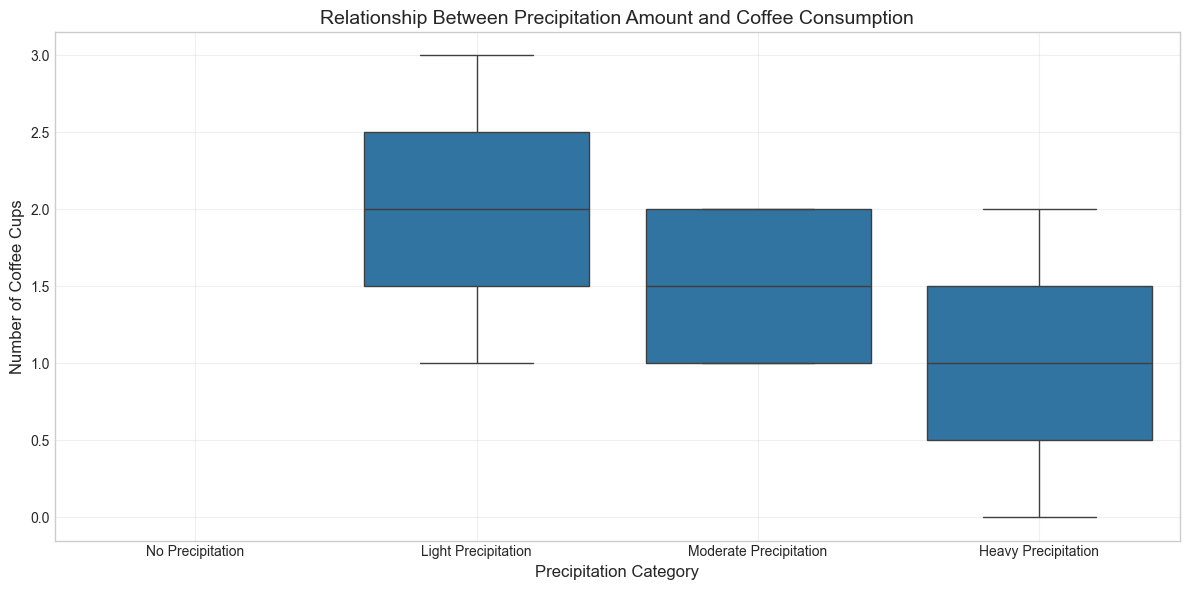

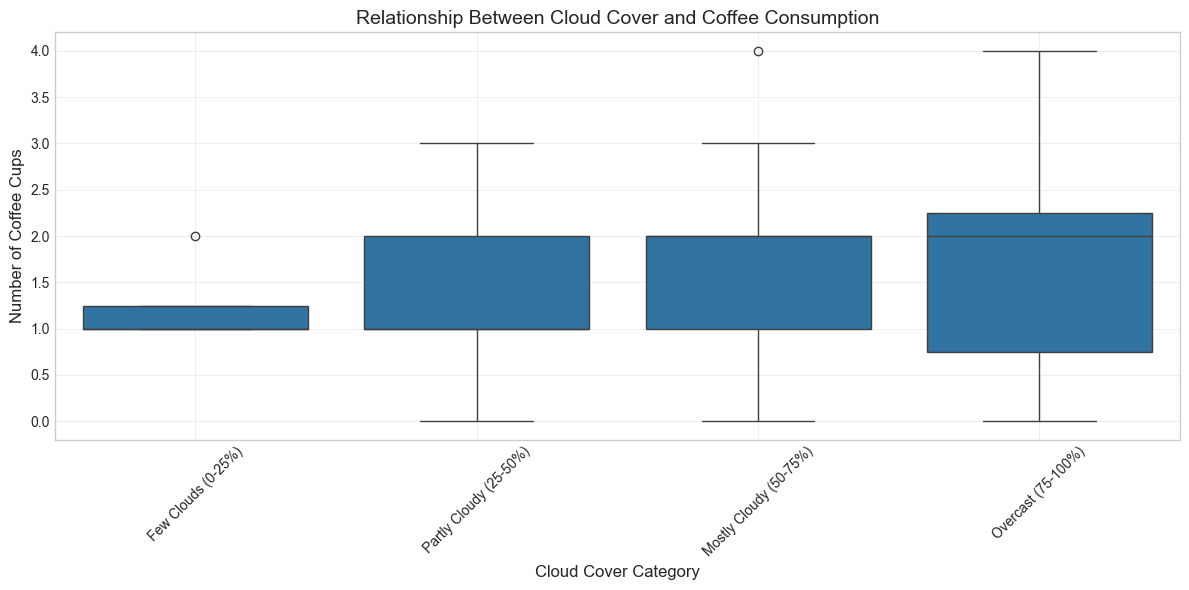

In [27]:
weather_coffee_analysis(df)


Analyzing the relationship between academic events and coffee consumption...

Exam/Assignment Days vs Normal Days Analysis:
Number of exam/assignment days: 10
Number of normal days: 33
Average coffee consumption on exam/assignment days: 1.40 cups
Average coffee consumption on normal days: 1.61 cups
T-statistic: -0.533, P-value: 0.6021
Result: No statistically significant difference found (p>0.05).


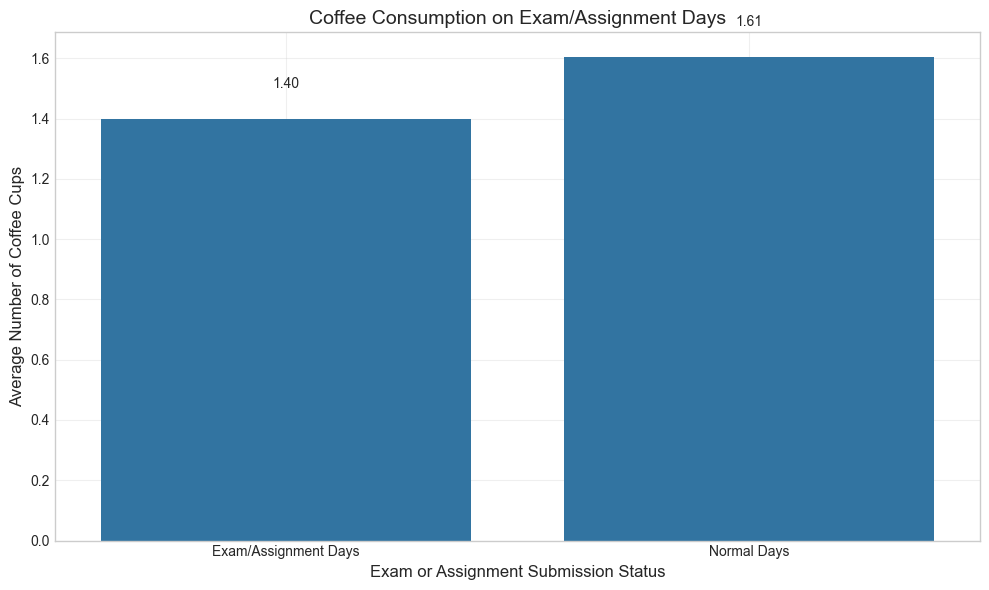

In [28]:
academic_coffee_analysis(df)


Analyzing the relationship between sleep and coffee consumption...


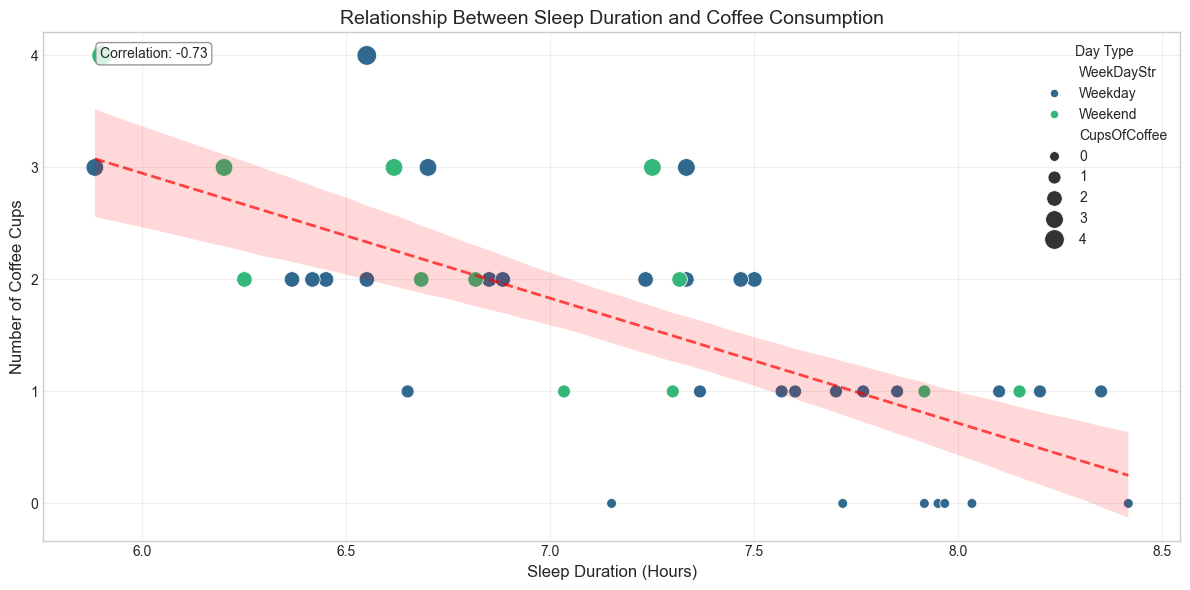

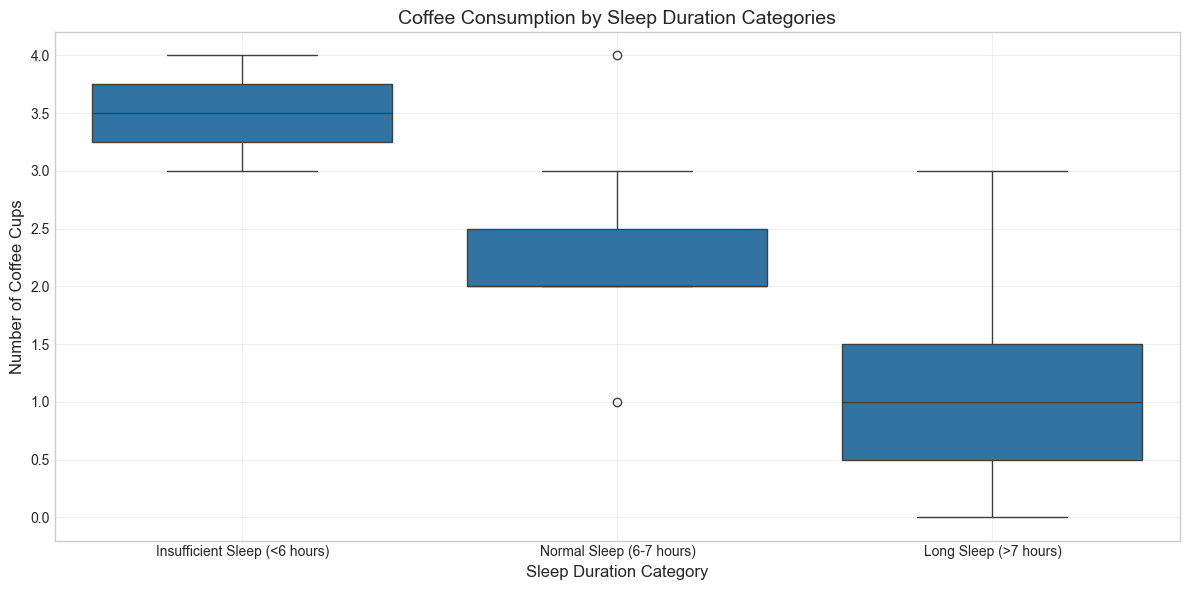

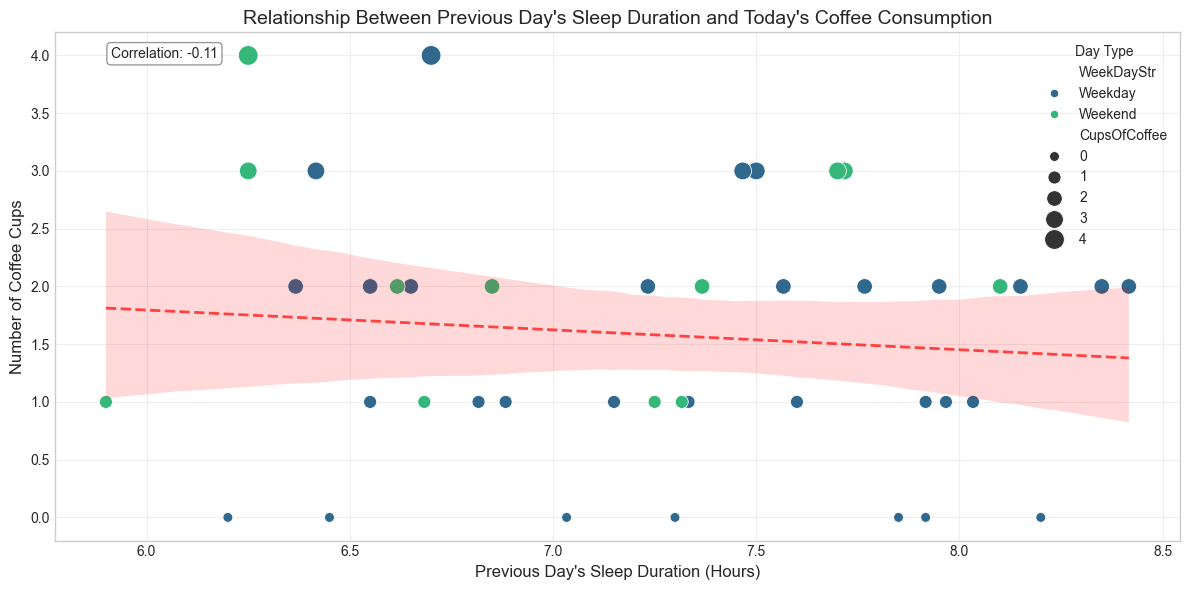

In [29]:
sleep_coffee_analysis(df)


Analyzing the combined effect of all factors...

Multiple Regression Analysis:

Coefficients:
- Sleep Duration: decreasing effect on coffee consumption (coefficient=-1.0707)
- Temperature: increasing effect on coffee consumption (coefficient=0.0142)
- Precipitation: decreasing effect on coffee consumption (coefficient=-0.0543)
- Cloud Cover: decreasing effect on coffee consumption (coefficient=-0.0003)
- Exam/Assignment: decreasing effect on coffee consumption (coefficient=-0.1220)
- Weekday: decreasing effect on coffee consumption (coefficient=-0.2889)

Constant (Intercept): 9.4406
Model R² score: 0.5503

Most influential factors (by absolute magnitude):
1. Sleep Duration: -1.0707
2. Weekday: -0.2889
3. Exam/Assignment: -0.1220
4. Precipitation: -0.0543
5. Temperature: 0.0142
6. Cloud Cover: -0.0003


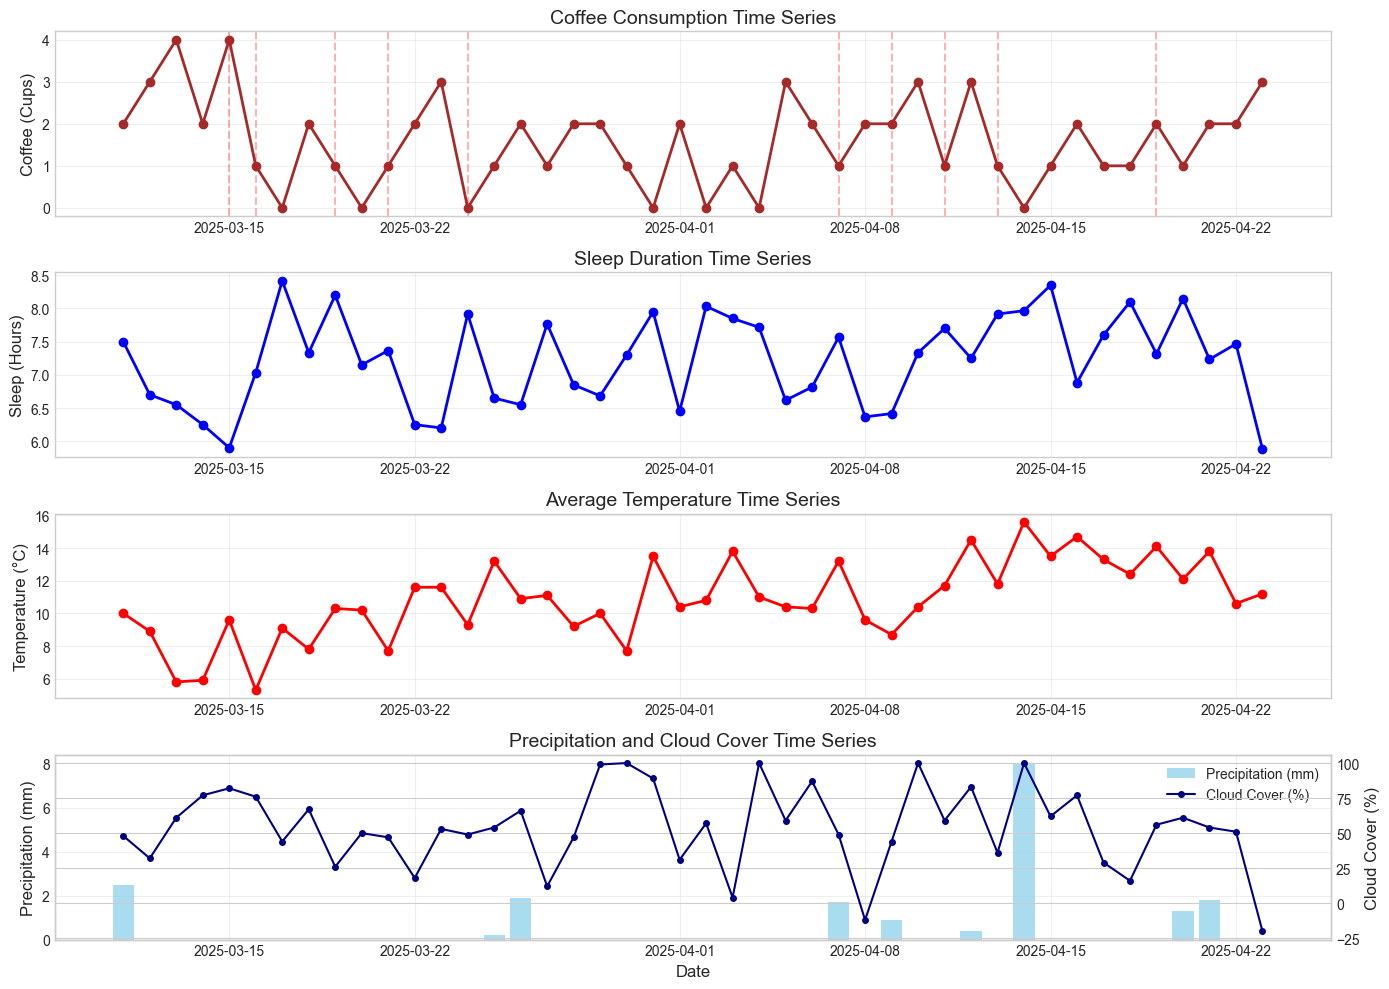

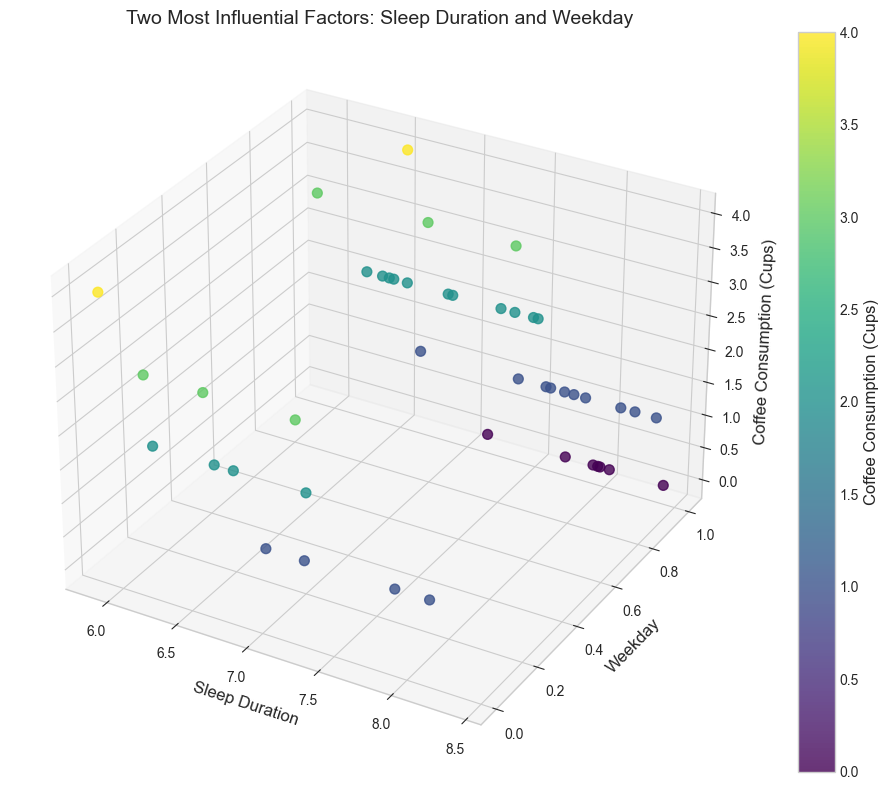

In [30]:
combined_factors_analysis(df)